#Reward

- Use Wasserstein GAN (WGAN), an improved version of the original GAN that uses the Wasserstein-l distance(also known as Earth-Mover distance) with Gradient Penalty(WGAN-GP) as reward
- Objective of discriminator in WGAN: maxD  Ey∼μ[D(y)] − Ex∼ν [D(x)]|D: Discriminator, ν and μ are the fake samples and real samples distribution
- Fake sample are pairs of a painting and its target, real samples are two same target images


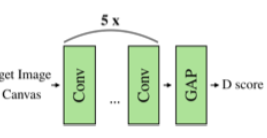

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam, SGD
from torch import autograd
from torch.autograd import Variable
import torch.nn.functional as F
from torch.autograd import grad as torch_grad
import torch.nn.utils.weight_norm as weightNorm
from utils.util import *

##TReLU

In [ ]:
class TReLU(nn.Module):
    def __init__(self):
            super(TReLU, self).__init__()
            self.alpha = nn.Parameter(torch.FloatTensor(1), requires_grad=True)
            self.alpha.data.fill_(0)

    def forward(self, x):
        x = F.relu(x - self.alpha) + self.alpha
        return x

##Discriminator

In [ ]:
class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()

            self.conv0 = weightNorm(nn.Conv2d(6, 16, 5, 2, 2))
            self.conv1 = weightNorm(nn.Conv2d(16, 32, 5, 2, 2))
            self.conv2 = weightNorm(nn.Conv2d(32, 64, 5, 2, 2))
            self.conv3 = weightNorm(nn.Conv2d(64, 128, 5, 2, 2))
            self.conv4 = weightNorm(nn.Conv2d(128, 1, 5, 2, 2))
            self.relu0 = TReLU()
            self.relu1 = TReLU()
            self.relu2 = TReLU()
            self.relu3 = TReLU()

        def forward(self, x):
            x = self.conv0(x)
            x = self.relu0(x)
            x = self.conv1(x)
            x = self.relu1(x)
            x = self.conv2(x)
            x = self.relu2(x)
            x = self.conv3(x)
            x = self.relu3(x)
            x = self.conv4(x)
            x = F.avg_pool2d(x, 4)
            x = x.view(-1, 1)
            return x


###Calculate Gradient Penalty

In [ ]:
def cal_gradient_penalty(netD, real_data, fake_data, batch_size):
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand(batch_size, int(real_data.nelement()/batch_size)).contiguous()
    alpha = alpha.view(batch_size, 6, dim, dim)
    alpha = alpha.to(device)
    fake_data = fake_data.view(batch_size, 6, dim, dim)
    interpolates = Variable(alpha * real_data.data + ((1 - alpha) * fake_data.data), requires_grad=True)
    disc_interpolates = netD(interpolates)
    gradients = autograd.grad(disc_interpolates, interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

###Calculate Reward

In [ ]:
def cal_reward(fake_data, real_data):
    return target_netD(torch.cat([real_data, fake_data], 1))

###Update Reward

In [ ]:
def update(fake_data, real_data):
    fake_data = fake_data.detach()
    real_data = real_data.detach()
    fake = torch.cat([real_data, fake_data], 1)
    real = torch.cat([real_data, real_data], 1)
    D_real = netD(real)
    D_fake = netD(fake)
    gradient_penalty = cal_gradient_penalty(netD, real, fake, real.shape[0])
    optimizerD.zero_grad()
    D_cost = D_fake.mean() - D_real.mean() + gradient_penalty
    D_cost.backward()
    optimizerD.step()
    soft_update(target_netD, netD, 0.001)
    return D_fake.mean(), D_real.mean(), gradient_penalty

###Save and Load GAN

In [ ]:
def save_gan(path):
    netD.cpu()
    torch.save(netD.state_dict(),'{}/wgan.pkl'.format(path))
    netD.to(device)

def load_gan(path):
    netD.load_state_dict(torch.load('{}/wgan.pkl'.format(path)))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dim = 128
LAMBDA = 10 # Gradient penalty lambda hyperparameter

In [ ]:
netD = Discriminator()
target_netD = Discriminator()
netD = netD.to(device)
target_netD = target_netD.to(device)
hard_update(target_netD, netD)

optimizerD = Adam(netD.parameters(), lr=3e-4, betas=(0.5, 0.999))